In [56]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
#import category_encoders as ce
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import iqr,skew 
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler,PowerTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

import pickle

import time
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns',15)
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) #Limiting floats output to 5 decimal points

In [57]:
#Importing Data sets
file_path_train= 'C:/Users/lcast/Desktop/DS/GitHub/Loan-Approval-Prediction/data/raw/train_Loan.csv'
file_path_test='C:/Users/lcast/Desktop/DS/GitHub/Loan-Approval-Prediction/data/raw/test_Loan.csv'
loan_train=pd.read_csv(file_path_train)
loan_test=pd.read_csv(file_path_test)

### 3. DATA TREATMENT
#### 3.1 MISSING VALUES (Imputation)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Text(0.5, 1.0, 'Percent missing data by feature')

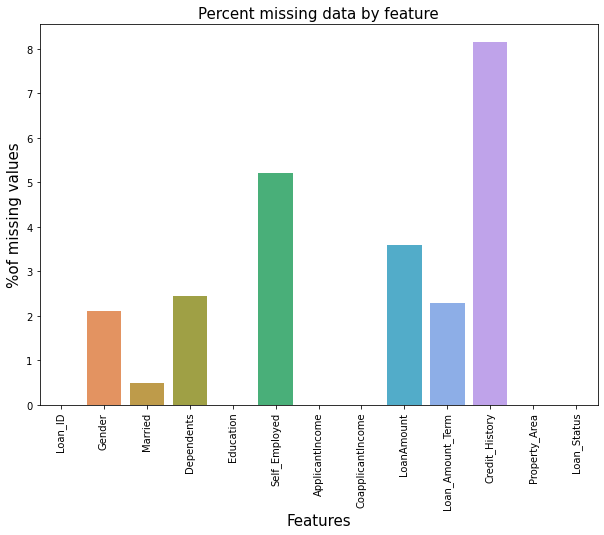

In [58]:
print(loan_train.isnull().sum())
null_percentage = (loan_train.isnull().sum() / len(loan_train)) * 100

plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.barplot(x=null_percentage.index, y=null_percentage)
plt.xlabel('Features', fontsize=15)
plt.ylabel('%of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

We see that there are several features with missing values. To deal with the missing values there are different strategies. One is just to get rid of all entries with missing values. But if we do that, we will eliminate a total 134 entries, which represents almost a 22% of the dataset. A second strategy is to treat the missing values as an additional category. And a third option is to we impute the missing values. We will use this third option starting by imputing single values. Perhaps later we will also consider multiple imputation methods.

In [59]:
#Gender imputation
loan_train.Gender.isnull().sum()

13

There are a total of 13 values null for gender. We have seen that 80% of the applicants in the dataset are male, so we could just impute the mode for the missing value. But since the dataset is not that large, it may be worth to take a closer look to the data and try to refine the imputation by finding any case were it makes sense to impute female instead. From the EDA and the chi independent test we have identified Married, Dependents and Property_Area as correlated to gender. Let's first check the distribution of gender by marital status:

In [60]:
loan_train.groupby(['Gender','Married']).Gender.count()

Gender  Married
Female  No          80
        Yes         31
Male    No         130
        Yes        357
Name: Gender, dtype: int64

There are 111 applicants female vs 487 male.  Out of the total of married (388), 31 are female and 357 are male,meaning that only 8% of the married applicants  are female. So for all applicants with gender missing and married, it makes sense to impute male. 

For those applicants not married, let's now check  the variable 'Dependents' to see if we find any hint:


In [61]:
loan_train[loan_train['Married']=='No'].groupby(['Gender','Married','Dependents']).Gender.count()

Gender  Married  Dependents
Female  No       0              60
                 1              13
                 2               2
                 3+              3
Male    No       0             109
                 1              10
                 2               6
                 3+              3
Name: Gender, dtype: int64

Distribution by dependents is similar for both genders, with a clear predominance of 0 dependents for both genders. Therefore, we canot use the dependents to refine the gender imputation.
By using Married and Dependents we have not been able to find any specific case were it makes sense to impute female.  we will just impute the mode (male)  for the gender missing values:

In [62]:
Gender_mode=loan_train['Gender'].mode()[0]
loan_train['Gender']=loan_train['Gender'].fillna(Gender_mode)

In [63]:
#Married
loan_train.Married.isnull().sum()

3

There are just 3 missing values. In the dataset, 213 (35%) are not married and 398 (65%) are married.The most related variables to married are gender and dependents. But as we have just seen before, we can't use them to refine the estimate, so we will just impute the mode (married) to all three missing values.

In [64]:
Married_mode=loan_train['Married'].mode()[0]
loan_train['Married']=loan_train['Married'].fillna(Married_mode)

In [65]:
#Dependents
loan_train.Dependents.isnull().sum()

15

Dependents variable has 15 missing values.Most related variables are Married and Gender. If Married is No, we will impute 0 since represents alsmot 82% of the cases. When Married is yes, the distribution by gender does not allow to select 1,2 or +3 dependents over 0. So we will  impute the mode (0) as well.

In [66]:
loan_train[loan_train['Married']=='Yes'].groupby(['Gender','Married','Dependents']).Gender.count()

Gender  Married  Dependents
Female  Yes      0              20
                 1               6
                 2               5
Male    Yes      0             154
                 1              73
                 2              88
                 3+             44
Name: Gender, dtype: int64

In [67]:
Dependents_mode=loan_train['Dependents'].mode()[0]
loan_train['Dependents']=loan_train['Dependents'].fillna(Dependents_mode)

For Self_Employed and Loan_Amount_term there are 32 missing values and 14, respectively. Since we didn't find any associated variable, we will impute the mode for both:

In [68]:
loan_train[['Self_Employed','Loan_Amount_Term']].isnull().sum()

Self_Employed       32
Loan_Amount_Term    14
dtype: int64

In [69]:
Self_employed_mode=loan_train['Self_Employed'].mode()[0]
loan_train['Self_Employed']=loan_train['Self_Employed'].fillna(Self_employed_mode)
loan_train['Loan_Amount_Term'].unique()

array([360., 120., 240.,  nan, 180.,  60., 300., 480.,  36.,  84.,  12.])

In the case of Loan term there are no missing values. However, we see that there are two mortgages with 36 months term and one with 12 months term.  Mortgages of 2 and 3 years are rare so we can suspect that actually is those values ara missing 0 by mistake and real values are 360 and 120 (30 and 10 years).In a real scenario, we will ask to the provider of the information to verify the values. However, since here we don't have a way to do the verification we will leave the values as they are.

In [70]:
loan_train.loc[(loan_train['Loan_Amount_Term']== 12) | (loan_train['Loan_Amount_Term']== 36)]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
262,LP001870,Female,No,1,Graduate,No,3481,0.00000,155.00000,36.00000,1.00000,Semiurban,N
497,LP002588,Male,Yes,0,Graduate,No,4625,2857.00000,111.00000,12.00000,nan,Urban,Y
546,LP002768,Male,No,0,Not Graduate,No,3358,0.00000,80.00000,36.00000,1.00000,Semiurban,N


In [71]:
Loan_Amount_Term_mode=loan_train['Loan_Amount_Term'].mode()[0]
loan_train['Loan_Amount_Term']=loan_train['Loan_Amount_Term'].fillna(Loan_Amount_Term_mode)

In [72]:
#Credit History
loan_train['Credit_History'].isnull().sum()

50

50 missing credit history values.  85% od the applicants in the dataset have credit history, so assuming that the values with missing Credit History are random, if we impute the mode (credit History "yes") we have 85% chances to impute the right value. 

In [73]:
Credit_History_mode=loan_train['Credit_History'].mode()[0]
loan_train['Credit_History']=loan_train['Credit_History'].fillna(Credit_History_mode)


**Note**: since Credit History is strongly correlated to the loan approval decission, alternative imputation methods were used. In particular, iterative imputer with different estimators was tried. No improvement was obtained so t has been excluded of this notebook. The code it's is included in the... 

Lastly, for LoanAmount there are 22 missing values. Given that there are many extreme values in the dataset, we will replace the missing values with the median (146) rather than with the mean (128)

In [74]:
LoanAmount_median=loan_train['LoanAmount'].median()
loan_train['LoanAmount']=loan_train['LoanAmount'].fillna(LoanAmount_median)

In [75]:
#Confirm there are no null values reamining
loan_train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### 3.2 Correct skewness

As we have seen before, all numerical variables (Applicant Income, CoApplicant Income and Loan Amount) have a positive skew. This can imply that some of the algorithms we will use later might be trained in a much larger number of moderate values than extreme values, resulting in a  model less likely to predict correctly the most extreme values. To correct this behaviour we will apply a log tranformation. 

Although we will work later in the feature engineering, it makes sense since the beginning to create a unique variable that combine both applicant and coapplicant incomes. To this combined variable we apply the log tranformation.

In [76]:
#Creating a Total income variable and applying a log transformation
loan_train['Total_Income']=loan_train['ApplicantIncome']+loan_train['CoapplicantIncome']
loan_train['Total_Income_log']=np.log(loan_train['Total_Income'])
loan_train['LoanAmount_log']=np.log(loan_train['LoanAmount'])

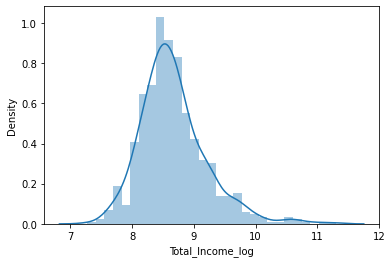

In [77]:
sns.distplot(loan_train['Total_Income_log'])
plt.show()

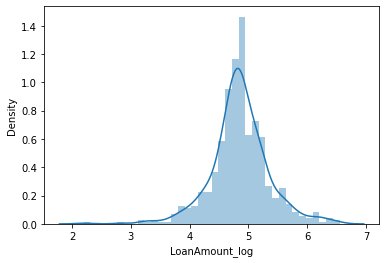

In [78]:
sns.distplot(loan_train['LoanAmount_log'])
plt.show()

### 3.3 Categorical into indicator variables (dummy variables)
The last step is to convert the categorical variables into dummy/indicator variables.

In [79]:
#Saving the ID of the records
loan_train_ID=loan_train.Loan_ID
loan_train.drop(['Loan_ID'],axis=1,inplace=True)
loan_train =pd.get_dummies(loan_train,drop_first=True)

### Preprocessing the test set

We repeat the same steps for the test data. Notice that to impute the missing values, the mode of the train set is used

In [83]:
loan_test['Gender']=loan_test['Gender'].fillna(Gender_mode)
loan_test['Married']=loan_test['Married'].fillna(Married_mode)
loan_test['Dependents']=loan_test['Dependents'].fillna(Dependents_mode)
loan_test['Self_Employed']=loan_test['Self_Employed'].fillna(Self_employed_mode)
loan_test['Loan_Amount_Term']=loan_test['Loan_Amount_Term'].fillna(Loan_Amount_Term_mode)
loan_test['Credit_History']=loan_test['Credit_History'].fillna(Credit_History_mode)
loan_test['LoanAmount']=loan_test['LoanAmount'].fillna(LoanAmount_median)


In [84]:
loan_test['Total_Income']=loan_test['ApplicantIncome']+loan_test['CoapplicantIncome']
loan_test['Total_Income_log']=np.log(loan_test['Total_Income'])
loan_test['LoanAmount_log']=np.log(loan_test['LoanAmount'])

In [85]:
loan_test_ID=loan_test.Loan_ID
loan_test.drop(['Loan_ID'],axis=1,inplace=True)
loan_test =pd.get_dummies(loan_test,drop_first=True)

In [88]:
#Saving the processed files
file_path= 'C:/Users/lcast/Desktop/DS/GitHub/Loan-Approval-Prediction/data/processed/'

loan_train.to_pickle(file_path+ 'loan_train_prepro.pkl')
loan_test.to_pickle(file_path+ 'loan_test_prepro.pkl')
loan_test_ID.to_pickle(file_path+ 'loan_test_ID.pkl')

In [87]:
loan_test_ID

0      LP001015
1      LP001022
2      LP001031
3      LP001035
4      LP001051
         ...   
362    LP002971
363    LP002975
364    LP002980
365    LP002986
366    LP002989
Name: Loan_ID, Length: 367, dtype: object